# Statistical Learning Assignment

>***Name***: Matheus Felipe Eduardo Barbosa  
>***Student ID***: XXXXXXXXXX  

This is my implementation of the first practical assignment of the 'DCC049 - Machine Learning' class. The main objective was to apply some statistical learning algorithms in a toy ML dataset to fix the concepts learned throughout the discipline.

## Importing libraries

These are the libraries that I will be using. All ML algorithms used are those provided by the **scikit-learn** suite. To handle data I will be using **numpy** and **pandas** libraries. Finally, to plot some charts I'll make use of **matplotlib** and **seaborn**. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import recall_score,precision_score,accuracy_score,auc,roc_curve,f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold

from scipy import interp

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(10,10)})

## Dataset - KOI Data
The data describes a series of spatial objects (Kepler Object
of Interest - KOI) identified by the NASA’s Kepler spacecraft <sup id="a1">[1](#a1)</sup>. The objective here is to classify an object as a an exoplanet or not.

Each row in the dataset consists of 43 features that describe an object. The column **koi_dispostion** is the categorical feature we want to predict.

<sup>[1](#a1)Avaible at https://exoplanetarchive.ipac.caltech.edu/. </sup>

In [2]:
data = pd.read_csv('koi_data.csv')
data.head(3)

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276


I will start cleaning the data by droping the column that encodes the object name and the target column, and assign the values to an array ***X_raw***. The ***y_raw*** array holds the targets for every observation.  

In [3]:
X_raw = data.drop(['koi_disposition','kepoi_name'], axis=1).values
y_raw = data[['koi_disposition']].values
X_raw [0],y_raw[0]

(array([ 9.488040e+00,  1.460000e-01,  2.957500e+00,  6.158000e+02,
         2.234000e-02,  3.207960e+00,  2.260000e+00,  8.530000e-02,
         8.966000e+01,  7.930000e+02,  9.359000e+01,  2.481000e+01,
         5.135850e+00,  2.847082e+01,  3.580000e+01,  5.455000e+03,
         4.467000e+00,  1.400000e-01,  9.270000e-01,  9.190000e-01,
         1.534700e+01,  1.589000e+01,  1.527000e+01,  1.511400e+01,
         1.500600e+01,  1.408200e+01,  1.375100e+01,  1.364800e+01,
         2.000000e-03,  1.946229e+01,  4.814191e+01,  4.300000e-01,
         9.400000e-01, -2.000000e-04, -5.500000e-04, -1.000000e-02,
         2.000000e-01,  2.000000e-01,  8.000000e-02,  3.100000e-01,
         3.200000e-01]), array(['CONFIRMED'], dtype=object))

As the sklearn library needs targets encoded by integers, I will encode the ***y_raw*** array to a binary array ***y***, encoding success to 1 and fail to 0.

In [4]:
y = np.array([1 if a=='CONFIRMED' else 0 for a in y_raw])
y[0:6]

array([1, 1, 0, 1, 0, 1])

To get better overall results, I will scale the data using the sklearn's ***StandardScaler***. Here the data will be scaled to a new distribution where the mean is 0 and the standard deviation is 1.

In [5]:
X = StandardScaler().fit_transform(X_raw)

display(round(np.mean(X,axis=0,dtype=np.float64)[0],5))
display(round(np.std(X,axis=0,dtype=np.float64)[0],5))

0.0

1.0

To do cross-validation I've implemented a utility function that does all the job. The ***cross_evaluate*** method takes a sklearn model, the data examples, the targets, the folds, and a error metric function, and evaluates the model the following way:

- For each of the ***k*** folds, it fits the model to every fold but the k-th.
- Evaluate the metric function using the examples and targets of the k-th fold <sup id="a1">[1](#a2)</sup>, and accumulate the result.
- Finally, the function returns the average of the accumulated results

So, for now on, I will be using this function to evaluate all algorithms (with a ***k***=5).

<sup>[1](#a2)For convenience, I made the function also return the averaged train results. </sup>

In [6]:
def cross_evaluate(model, X, y, folds, metric_f):
    mean_acc = 0
    train_acc = 0
    for train_index, test_index in folds:
        X_train, y_train = X[train_index],y[train_index]
        X_test, y_test = X[test_index],y[test_index]

        trained_model = model.fit(X_train,y_train)
        
        y_pred = trained_model.predict(X_test)
        mean_acc += metric_f(y_test, y_pred)
        
        y_pred = trained_model.predict(X_train)
        train_acc += metric_f(y_train, y_pred)

    return mean_acc / k, train_acc/ k

k=5
skf = StratifiedKFold(n_splits=k)
folds = list(skf.split(X, y))

best_model = {}
best_result = {}

## Naive Bayes
Naive Bayes is a very simple algorithm to get started. It is a probabilistic classifier based on the Bayes' theorem. It is named like that because it works by assuming mutual independence between the features. That way, it make predictions by using the likehood of every feature value belonging to a class. Because of its simplicity, it is often used as a baseline to evaluate more complex models. 

With sklearn's default Gaussian Naive Bayes I got a pretty good accuracy of 91%. That'll be our baseline score. 

In [7]:
gnb = GaussianNB()

baseline,_ = cross_evaluate(gnb,X,y,folds,accuracy_score)

best_model['Naive Bayes'] = gnb
best_result['Naive Bayes'] = baseline

print("Mean accuracy: ",baseline)

Mean accuracy:  0.918879557559616


## Decision Tree
Decision Trees are a well known category of statistical model for classification tasks. The standard way of implementing it is based on the recursive splitting of the data across the binary tree. Each node splits the examples using a feature and a threshold, propagating the halves to the child nodes. That way, it continues splitting the data in a top-down manner until one of two criterions is met: until you reach a pure state (were every example belongs to a single class), or a specific top criterion is met, like the max tree depth (were the leaf nodes will be left with a class probability).


Using the sklearn's default parameters for the classifier, we can get a significant improvement over the baseline, with a 94% accuracy.

In [8]:
dtc = DecisionTreeClassifier()

mean_acc,_ = cross_evaluate(dtc,X,y,folds,accuracy_score)

best_model['Decision Tree'] = dtc
best_result['Decision Tree'] = mean_acc

print("Mean accuracy: ",mean_acc)

Mean accuracy:  0.9388633010015728


It is possible to verify the algorithm's behavior by varying the ***max depth*** parameter. Here you can see the results:

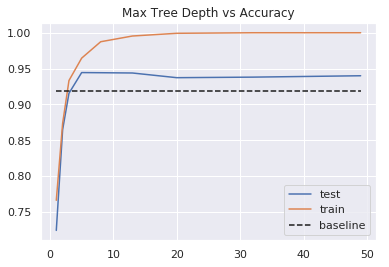

'Best mean accuracy: 0.9444411537917471'

In [9]:
tree_size =  list(np.geomspace(1, 50, num=10, dtype=int)) + [None]
test_acc = [ ]
train_acc = [ ]

for s in tree_size:
    dtc = DecisionTreeClassifier(max_depth = s)
    tt_acc, tr_acc = cross_evaluate(dtc,X,y,folds,accuracy_score)
    
    if(tt_acc > best_result['Decision Tree']):
        best_result['Decision Tree'] = tt_acc
        best_model['Decision Tree'] = dtc
    
    train_acc.append(tr_acc)
    test_acc.append(tt_acc)
    
plt.plot(tree_size,test_acc, label='test')
plt.plot(tree_size,train_acc, label='train')
plt.plot(tree_size,[baseline for _ in tree_size],'k--', label='baseline')
plt.title("Max Tree Depth vs Accuracy")
plt.gca().legend(('test','train','baseline'))
plt.show()

display("Best mean accuracy: "+str(best_result['Decision Tree']))

The results shows how the model overfits with big enough trees. While the training accuracy grows fast with bigger trees, reaching 100% at some point, the test error begins to increase when the model becomes too big. That's because bigger trees translate to more specific leaf nodes, reaching a point where every leaf can have single examples.

## Support Vector Machines

In [10]:
svc = SVC(probability=True)

mean_acc,_ = cross_evaluate(svc,X,y,folds,accuracy_score)

best_model['SVM'] = svc
best_result['SVM'] = mean_acc

print("Mean accuracy: ",mean_acc)

Mean accuracy:  0.9350273149717723


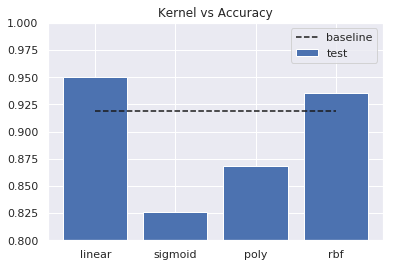

'Best mean accuracy: 0.9500182658694708'

In [11]:
kernels = ['linear','sigmoid','poly','rbf']
test_acc = []

for kr in kernels:
    svc = SVC(kernel = kr,probability=True)
    tt_acc, _ = cross_evaluate(svc,X,y,folds,accuracy_score)
    
    if(tt_acc > best_result['SVM']):
        best_result['SVM'] = tt_acc
        best_model['SVM'] = svc
    
    test_acc.append(tt_acc)
    
plt.bar(kernels,test_acc,label='test')
plt.plot(kernels,[baseline for _ in range(0,len(kernels))],'k--', label='baseline')
plt.title("Kernel vs Accuracy")
plt.gca().legend(('baseline','test'))
plt.ylim((0.8,1.0))
plt.show()

display("Best mean accuracy: "+str(best_result['SVM']))

## KNN Classifier

In [12]:
knn = KNeighborsClassifier()

mean_acc,_ = cross_evaluate(knn,X,y,folds,accuracy_score)

best_model['KNN'] = knn
best_result['KNN'] = mean_acc

print("Mean accuracy: ",mean_acc)

Mean accuracy:  0.8850485419130522


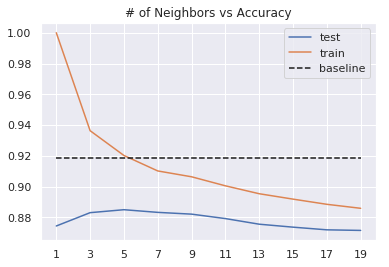

'Best mean accuracy: 0.8850485419130522'

In [13]:
n_neigh =  list(range(1,20,2))
test_acc = [ ]
train_acc = [ ]
for n in n_neigh:
    knn = KNeighborsClassifier(n_neighbors=n)
    tt_acc, tr_acc = cross_evaluate(knn,X,y,folds,accuracy_score)
    
    if(tt_acc > best_result['KNN']):
        best_result['KNN'] = tt_acc
        best_model['KNN'] = knn
    
    train_acc.append(tr_acc)
    test_acc.append(tt_acc)
    
plt.plot(n_neigh,test_acc, label='test')
plt.plot(n_neigh,train_acc, label='train')
plt.plot(n_neigh,[baseline for _ in n_neigh],'k--', label='baseline')
plt.title("# of Neighbors vs Accuracy")
plt.gca().legend(('test','train','baseline'))
plt.xticks(list(range(1,20,2)))
plt.show()

display("Best mean accuracy: "+str(best_result['KNN']))

## Random Forest

In [14]:
rfc = RandomForestClassifier()

mean_acc,_ = cross_evaluate(rfc,X,y,folds,accuracy_score)

best_model['Random Forest'] = rfc
best_result['Random Forest'] = mean_acc

print("Mean accuracy: ",mean_acc)

Mean accuracy:  0.9598204183023327


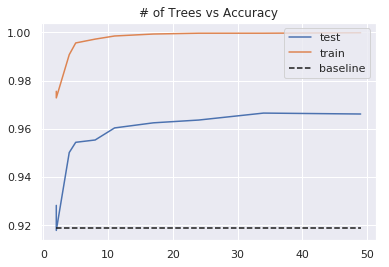

'Best mean accuracy: 0.9665493437529491'

In [15]:
n_trees =  list(np.geomspace(2, 50, num=10, dtype=int))
test_acc = [ ]
train_acc = [ ]
for s in n_trees:
    rfc = RandomForestClassifier(n_estimators = s)
    tt_acc, tr_acc = cross_evaluate(rfc,X,y,folds,accuracy_score)
    
    if(tt_acc > best_result['Random Forest']):
        best_result['Random Forest'] = tt_acc
        best_model['Random Forest'] = rfc
    
    train_acc.append(tr_acc)
    test_acc.append(tt_acc)
    
plt.plot(n_trees,test_acc, label='test')
plt.plot(n_trees,train_acc, label='train')
plt.plot(n_trees,[baseline for _ in n_trees],'k--', label='baseline')
plt.title("# of Trees vs Accuracy")
plt.gca().legend(('test','train','baseline'))
plt.show()

display("Best mean accuracy: "+str(best_result['Random Forest']))

## Gradient Boosting

In [16]:
gbc = GradientBoostingClassifier()

mean_acc,_ = cross_evaluate(gbc,X,y,folds,accuracy_score)

best_model['Gradient Boosting'] = gbc
best_result['Gradient Boosting'] = mean_acc

print("Mean accuracy: ",mean_acc)

Mean accuracy:  0.9652059626890015


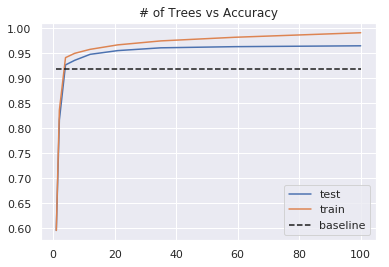

'Best mean accuracy: 0.9652059626890015'

In [17]:
n_trees =  list(np.geomspace(1, 100, num=10, dtype=int))
test_acc = [ ]
train_acc = [ ]
for s in n_trees:
    gbc = GradientBoostingClassifier(n_estimators = s)
    tt_acc, tr_acc = cross_evaluate(gbc,X,y,folds,accuracy_score)
    
    if(tt_acc > best_result['Gradient Boosting']):
        best_result['Gradient Boosting'] = tt_acc
        best_model['Gradient Boosting'] = gbc    
    
    train_acc.append(tr_acc)
    test_acc.append(tt_acc)
    
plt.plot(n_trees,test_acc, label='test')
plt.plot(n_trees,train_acc, label='train')
plt.plot(n_trees,[baseline for _ in n_trees],'k--', label='baseline')
plt.title("# of Trees vs Accuracy")
plt.gca().legend(('test','train','baseline'))
plt.show()

display("Best mean accuracy: "+str(best_result['Gradient Boosting']))

## Results

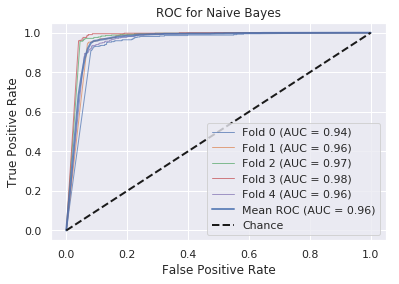

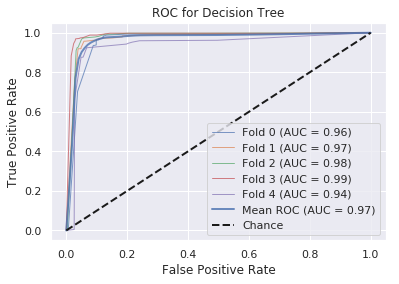

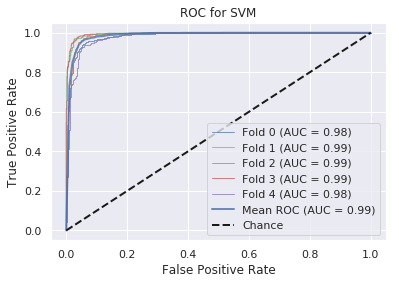

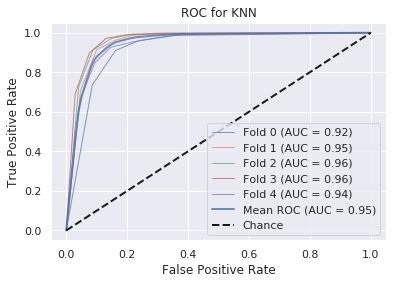

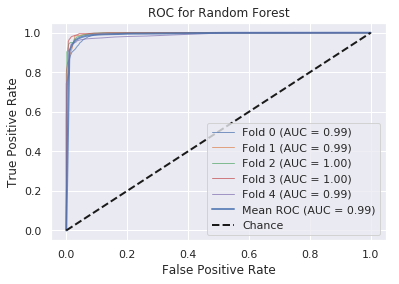

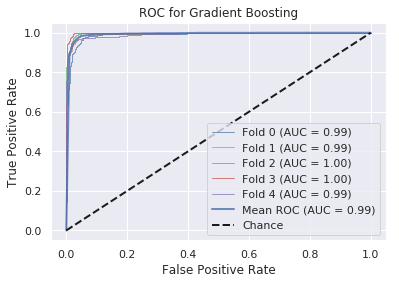

In [18]:
for n,(key, model) in enumerate(best_model.items()):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for i,(train_index, test_index) in enumerate(folds):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        
        probs = model.fit(X_train, y_train).predict_proba(X_test)

        fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
        
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=1, alpha=0.7,
             label='Fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f)' % (mean_auc),
             lw=2, alpha=.8)
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Chance')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for '+ key)
    plt.legend(loc="lower right")
    plt.show()

,accuracy,precision,recall,f1
Naive Bayes,0.918880,0.851867,0.968146,0.906227
Decision Tree,0.942326,0.913209,0.952443,0.931217
SVM,0.950018,0.919671,0.962440,0.940083
KNN,0.885049,0.799672,0.958160,0.871306
Random Forest,0.963474,0.961499,0.949596,0.953762
Gradient Boosting,0.965206,0.952807,0.962906,0.957305


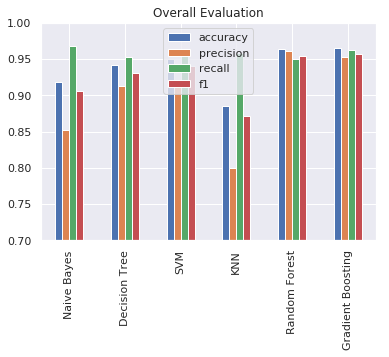

In [19]:
results = pd.DataFrame(columns=['accuracy','precision','recall','f1'])

for key, model in best_model.items():
    precision,_ = cross_evaluate(model,X,y,folds,precision_score)
    recall,_ = cross_evaluate(model,X,y,folds,recall_score)
    acc,_ = cross_evaluate(model,X,y,folds,accuracy_score)
    f1,_ = cross_evaluate(model,X,y,folds,f1_score)

    results = results.append(pd.Series(
                             {"accuracy": acc,
                              "precision": precision,
                              "recall": recall,
                              "f1": f1},name=key))
        
display(results)
results.plot(y=['accuracy','precision','recall','f1'], 
             kind='bar',ylim=(0.70,1.0),
             title='Overall Evaluation')
plt.show()

## Conclusions